In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [13]:
yield10y = pd.read_csv('./Datasets/10Yrs_Yield_unadjusted.csv')
cpi = pd.read_csv('./Datasets/CPI-U_unadjusted.csv')
fedFunds = pd.read_csv('./Datasets/FEDFUNDS.csv')
indProd = pd.read_csv('./Datasets/Industrial_Production.csv')
joblessClaim = pd.read_csv('./Datasets/Initial_jobless_claims.csv')
msciUsaValue = pd.read_csv('./Datasets/MSCI_USA_Value_Index.csv')
realGdp = pd.read_csv('./Datasets/RealGDP_adjusted.csv')
sp500Eps = pd.read_csv('./Datasets/s-p-500-earnings-history.csv')
vix = pd.read_csv('./Datasets/VIX_cboe_History.csv')

In [14]:
dfs_dict = {}
dfs_dict["10Yrs_Yield_unadjusted"] = yield10y
dfs_dict["CPI-U_unadjusted"] = cpi
dfs_dict["FEDFUNDS"] = fedFunds
dfs_dict["Industrial_Production"] = indProd
dfs_dict["Initial_Jobless_Claims"] = joblessClaim
dfs_dict["MSCI_USA_Value_Index"] = msciUsaValue
dfs_dict["RealGDP_adjusted"] = realGdp
dfs_dict["S&P_500_Earnings_History"] = sp500Eps
dfs_dict["VIX_Cboe_History"] = vix

In [15]:
def parse_datasets(df_list, dfs_dict):
    for name in df_list:
        try:
            df = dfs_dict[name]
            df_new = df.rename(columns={df.columns[0]: 'DateTime'})
            df_new['DateTime'] = pd.to_datetime(df_new['DateTime'])
            df_new.set_index('DateTime', inplace=True)
            df_new = df_new.sort_index()
            df_new = df_new[(df_new.index >='1999-01-01') & (df_new.index < '2026-01-01')]
            if df_new.columns.size < 2:
                df_new = df_new.rename(columns={df_new.columns[0]: 'value1'})
            dfs_dict[name] = df_new
        except Exception as e:
            print(f"Error in {name}: {e}")
            continue
    return dfs_dict

In [16]:
def plot_timelines(df_list, dfs_dict):
    rows = []
    for name in df_list:
        try:
            df = dfs_dict[name]
            start_time = df.index.min()
            end_time = df.index.max()
            max_interval = df.index.diff().max()
            rows.append({'Name': name, 'start': start_time, 'end': end_time, 'max_interval': max_interval})
        except Exception as e:
            print(f"Error in {name}: {e}")
            continue
    df_new = pd.DataFrame(rows)
    df_new.set_index('Name', inplace=True)
    return df_new

In [17]:
#to be used only for CPI-U and RealGDP_adjusted
def to_pct_change(df):
    df_pct = df.pct_change()
    return df_pct

In [18]:
dfs_list = list(dfs_dict.keys())
dfs_dict_new = parse_datasets(dfs_list, dfs_dict)
timeline_df = plot_timelines(dfs_list, dfs_dict)

/var/folders/sr/p42wz5n11rzcm2dvgg2x75l00000gn/T/ipykernel_33704/3654836538.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_new['DateTime'] = pd.to_datetime(df_new['DateTime'])
/var/folders/sr/p42wz5n11rzcm2dvgg2x75l00000gn/T/ipykernel_33704/3654836538.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_new['DateTime'] = pd.to_datetime(df_new['DateTime'])


In [19]:
display(timeline_df)

,start,end,max_interval
Name,,,
10Yrs_Yield_unadjusted,1999-01-01,2025-12-31,3 days
CPI-U_unadjusted,1999-01-01,2025-12-01,31 days
FEDFUNDS,1999-01-01,2025-12-01,31 days
Industrial_Production,1999-01-01,2025-12-01,31 days
Initial_Jobless_Claims,1999-01-02,2025-12-27,7 days
MSCI_USA_Value_Index,1999-01-01,2025-12-01,31 days
RealGDP_adjusted,1999-01-01,2025-07-01,92 days
S&P_500_Earnings_History,1999-01-01,2025-12-01,31 days
VIX_Cboe_History,1999-01-04,2025-12-31,7 days


In [ ]:
def plot_vs_vix(dfs_dict, vix_df, vix_style='line', recessions=[('2001-03-01', '2001-11-01'), ('2007-12-01', '2009-06-01'), ('2020-02-01', '2020-04-01')]):
    non_vix_dfs = {k: v for k, v in dfs_dict.items() if k != 'VIX_Cboe_History'}
    
    fig, axes = plt.subplots(len(non_vix_dfs), 1, figsize=(20, len(non_vix_dfs)*7))
    if len(non_vix_dfs) == 1:
        axes = [axes]
    
    for i, (name, df) in enumerate(non_vix_dfs.items()):
        ax1 = axes[i]
        ax2 = ax1.twinx()
        
        # Plot main data
        if name == 'S&P_500_Earnings_History':
            ax1.plot(df.index, df.iloc[:, 0], label='S&P 500', color='blue')
            ax3 = ax1.twinx()
            ax3.spines['right'].set_position(('outward', 60))
            ax3.plot(df.index, df.iloc[:, 1], label='EPS', color='black', linestyle='--')
            ax3.set_ylabel('EPS', color='black')
            ax3.legend(loc='upper center')
        else:
            ax1.plot(df.index, df.iloc[:, 0], label=name, color='blue')
        
        # Plot VIX
        if vix_style == 'candlestick':
            # Simple bar representation here
            colors = ['green' if vix_df.iloc[j, 3] >= vix_df.iloc[j, 0] else 'red' for j in range(len(vix_df))]
            ax2.bar(vix_df.index, vix_df.iloc[:, 3] - vix_df.iloc[:, 0], 
                   bottom=vix_df.iloc[:, 0], width=1, color=colors, alpha=0.3, label='VIX')
        else:
            ax2.plot(vix_df.index, vix_df.iloc[:, 3], label='VIX Close', color='red', alpha=0.6)
        
        # Shade recessions
        for start, end in recessions:
            ax1.axvspan(start, end, alpha=0.2, color='gray', zorder=0)
        
        ax1.set_ylabel(name, color='blue')
        ax2.set_ylabel('VIX', color='red')
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        ax1.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [28]:
def change_dtype(df):
    df['value1'] = pd.to_numeric(df['value1'], errors='coerce')
    return df
dfs_dict_new['CPI-U_unadjusted'] = change_dtype(dfs_dict_new['CPI-U_unadjusted'])

/var/folders/sr/p42wz5n11rzcm2dvgg2x75l00000gn/T/ipykernel_33704/3677938436.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_pct = df.pct_change()


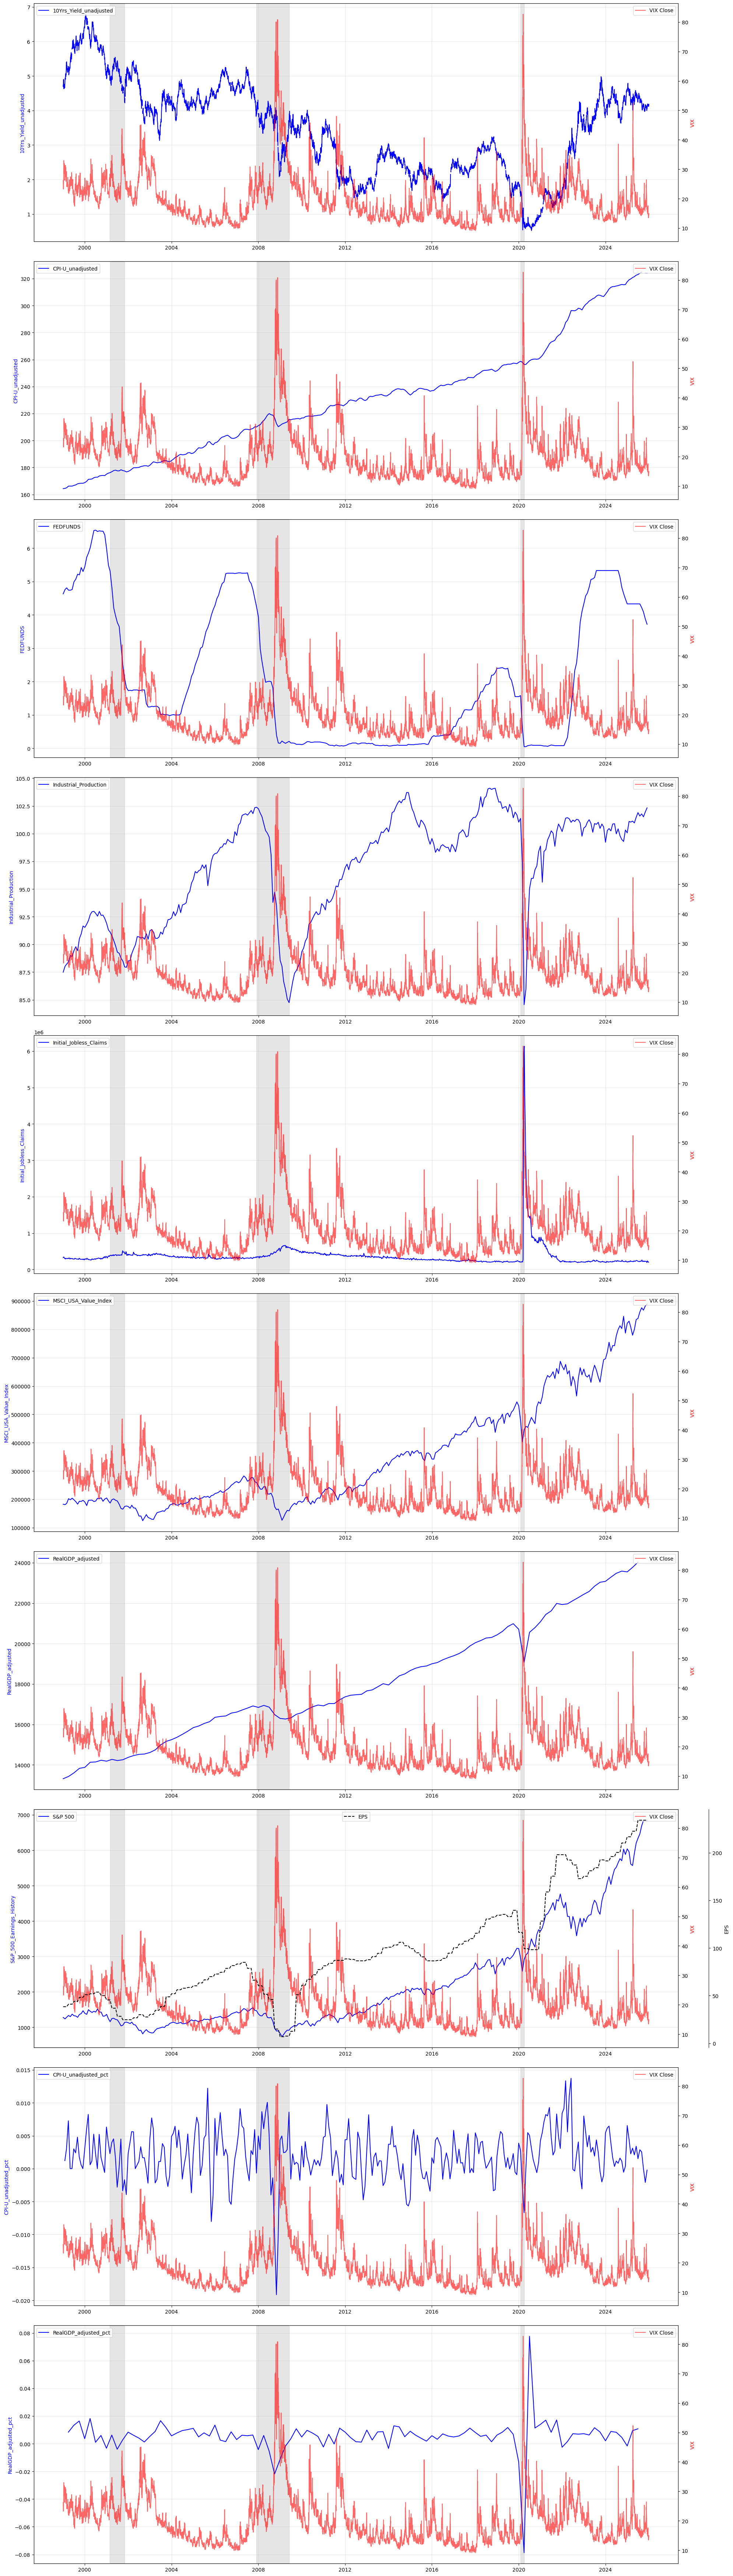

In [29]:
dfs_dict_new['CPI-U_unadjusted_pct'] = to_pct_change(dfs_dict_new['CPI-U_unadjusted'])
dfs_dict_new['RealGDP_adjusted_pct'] = to_pct_change(dfs_dict_new['RealGDP_adjusted'])
plot_vs_vix(dfs_dict_new, dfs_dict['VIX_Cboe_History'], vix_style='line')

In [43]:
def get_train_data(dfs_dict, end_period='2018-01-01'):
    train_data = {}
    for name, df in dfs_dict.items():
        train_data[name] = df[df.index < end_period]
    return train_data

In [45]:
dfs_dict_train = get_train_data(dfs_dict_new, end_period='2018-01-01')
display(plot_timelines(dfs_dict_train.keys(), dfs_dict_train))

,start,end,max_interval
Name,,,
10Yrs_Yield_unadjusted,1999-01-01,2017-12-29,3 days
CPI-U_unadjusted,1999-01-01,2017-12-01,31 days
FEDFUNDS,1999-01-01,2017-12-01,31 days
Industrial_Production,1999-01-01,2017-12-01,31 days
Initial_Jobless_Claims,1999-01-02,2017-12-30,7 days
MSCI_USA_Value_Index,1999-01-01,2017-12-01,31 days
RealGDP_adjusted,1999-01-01,2017-10-01,92 days
S&P_500_Earnings_History,1999-01-01,2017-12-01,31 days
VIX_Cboe_History,1999-01-04,2017-12-29,7 days


In [62]:
def detect_freq(df):
    deltas = df.index.to_series().diff().dt.days.dropna()
    max_delta = deltas.max()

    if max_delta <= 10:
        return 'W'
    elif max_delta <= 40:
        return 'ME'
    else:
        return 'QE'

In [63]:
def choose_common_freq(freq1, freq2):
    freq_order = ['W', 'ME', 'QE']
    f1 = freq1 if freq1 in freq_order else 'QE'
    f2 = freq2 if freq2 in freq_order else 'QE'

    idx1 = freq_order.index(f1)
    idx2 = freq_order.index(f2)

    common_freq = freq_order[max(idx1, idx2)]
    return common_freq

In [64]:
def adaptive_ccf(dfs_dict_train, df1_name, df2_name='VIX_Cboe_History', max_lags=10):
    freq1 = detect_freq(dfs_dict_train[df1_name])
    freq2 = detect_freq(dfs_dict_train[df2_name])
    common_freq = choose_common_freq(freq1, freq2)

    series1 = dfs_dict_train[df1_name].iloc[:, 0].dropna()
    series2 = dfs_dict_train[df2_name].iloc[:, 3].dropna()

    s1_resampled = series1.resample(common_freq).last()
    s2_resampled = series2.resample(common_freq).last()

    start = max(s1_resampled.index.min(), s2_resampled.index.min())
    end = min(s1_resampled.index.max(), s2_resampled.index.max())

    s1_aligned = s1_resampled[start:end]
    s2_aligned = s2_resampled[start:end]

    s1_clean = s1_aligned.dropna()
    s2_clean = s2_aligned.dropna()

    return (common_freq, ccf(s1_clean, s2_clean, adjusted=False)[:max_lags+1])

In [65]:
correlations_dict = {}
for name, dataset in dfs_dict_train.items():
    if name != 'VIX_Cboe_History':
        correlations_dict[name] = adaptive_ccf(dfs_dict_train, name)
print(correlations_dict)

{'10Yrs_Yield_unadjusted': ('W', array([0.13624599, 0.13258678, 0.12591435, 0.12064546, 0.11336389,
       0.10717493, 0.10113904, 0.09617811, 0.09287919, 0.0923501 ,
       0.09243116])), 'CPI-U_unadjusted': ('ME', array([-0.29561001, -0.2961329 , -0.29220688, -0.28357395, -0.27243245,
       -0.26178354, -0.25044211, -0.24084072, -0.23308967, -0.22713333,
       -0.22280057])), 'FEDFUNDS': ('ME', array([-0.00819596, -0.04248132, -0.06936156, -0.08979566, -0.10512035,
       -0.11852764, -0.13192722, -0.14566773, -0.15854286, -0.17089507,
       -0.182171  ])), 'Industrial_Production': ('ME', array([-0.549792  , -0.581776  , -0.61922802, -0.64667037, -0.65526712,
       -0.66217093, -0.66702498, -0.66418908, -0.65687895, -0.64304987,
       -0.62615697])), 'Initial_Jobless_Claims': ('W', array([0.60284694, 0.61128725, 0.62034434, 0.62728666, 0.63225072,
       0.63710583, 0.63948581, 0.64202081, 0.64616572, 0.64856012,
       0.65008434])), 'MSCI_USA_Value_Index': ('ME', array([-0.557

In [66]:
def analyze_ccf(dfs_dict_train, correlations_dict, name1, name2, col_name='value1', max_lags=10):
    freq, correlations = correlations_dict.get(name1)
    lags = np.arange(len(correlations))
    
    # Confidence interval
    n = len(dfs_dict_train[name1][col_name].resample(freq).last().dropna())
    conf_interval = 2.576 / np.sqrt(n)
    
    # Find significant peaks
    significant = np.abs(correlations) > conf_interval
    significant_lags = lags[significant]
    
    # Find maximum correlation
    max_idx = np.argmax(np.abs(correlations[1:])) + 1  # Skip lag 0
    max_corr = correlations[max_idx]
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.stem(lags, correlations, basefmt=' ')
    ax.axhline(y=0, color='black', linewidth=0.8)
    ax.axhline(y=conf_interval, color='red', linestyle='--', alpha=0.7, label=f'99% CI (±{conf_interval:.3f})')
    ax.axhline(y=-conf_interval, color='red', linestyle='--', alpha=0.7)
    ax.set_xlabel('Lag (periods)', fontsize=12)
    ax.set_ylabel('Correlation', fontsize=12)
    ax.set_title(f'Cross-Correlation: {name1} vs {name2}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Add annotation for peak
    ax.annotate(f'Peak: {max_corr:.3f}\nat lag {max_idx}',
                xy=(max_idx, max_corr),
                xytext=(max_idx+2, max_corr),
                arrowprops=dict(arrowstyle='->', color='blue'),
                fontsize=10, color='blue')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n{'='*60}")
    print(f"Cross-Correlation Analysis: {name1} → {name2}")
    print(f"{'='*60}")
    print(f"Sample size: {n}")
    print(f"99% Confidence interval: ±{conf_interval:.3f}")
    print(f"\nLag 0 correlation: {correlations[0]:.3f}")
    print(f"Peak correlation: {max_corr:.3f} at lag {max_idx}")
    print(f"\nSignificant lags: {significant_lags.tolist() if len(significant_lags) > 0 else 'None'}")
    
    # Interpretation
    print(f"\n{'Interpretation:'}")
    if max_idx == 0:
        print(f"→ Strongest relationship is contemporaneous (same time period)")
    elif max_idx > 0:
        print(f"→ {name1} LEADS {name2} by {max_idx} period(s)")
        print(f"→ {name1} changes predict {name2} changes {max_idx} period(s) later")
    
    if max_corr > 0:
        print(f"→ Positive relationship: variables move in same direction")
    else:
        print(f"→ Negative relationship: variables move in opposite directions")
    
    if abs(max_corr) < 0.3:
        print(f"→ Weak correlation")
    elif abs(max_corr) < 0.7:
        print(f"→ Moderate correlation")
    else:
        print(f"→ Strong correlation")
    
    print(f"{'='*60}\n")
    
    return correlations, significant_lags

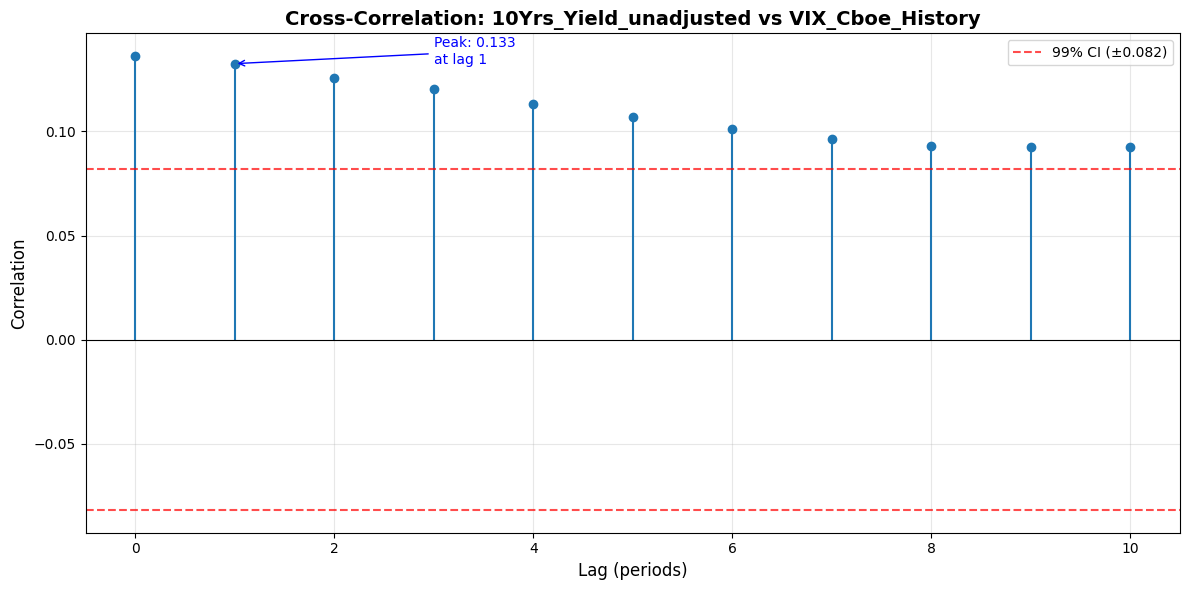


Cross-Correlation Analysis: 10Yrs_Yield_unadjusted → VIX_Cboe_History
Sample size: 991
99% Confidence interval: ±0.082

Lag 0 correlation: 0.136
Peak correlation: 0.133 at lag 1

Significant lags: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Interpretation:
→ 10Yrs_Yield_unadjusted LEADS VIX_Cboe_History by 1 period(s)
→ 10Yrs_Yield_unadjusted changes predict VIX_Cboe_History changes 1 period(s) later
→ Positive relationship: variables move in same direction
→ Weak correlation



In [67]:
correlations, sig_lags = analyze_ccf(dfs_dict_train, correlations_dict, 
                                      name1='10Yrs_Yield_unadjusted', 
                                      name2='VIX_Cboe_History')

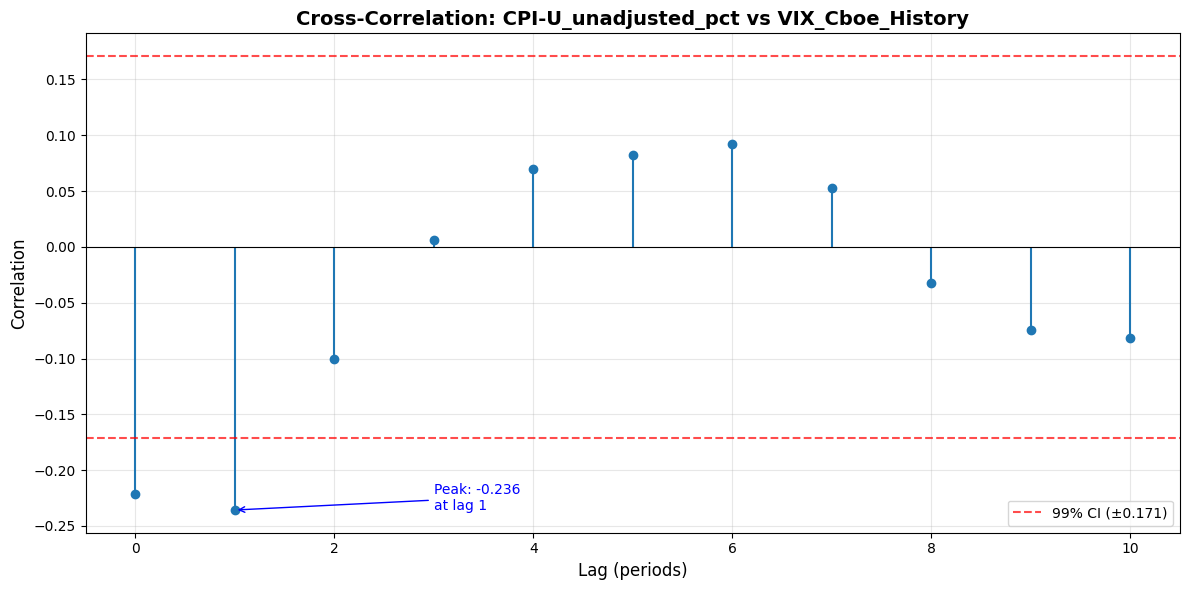


Cross-Correlation Analysis: CPI-U_unadjusted_pct → VIX_Cboe_History
Sample size: 227
99% Confidence interval: ±0.171

Lag 0 correlation: -0.221
Peak correlation: -0.236 at lag 1

Significant lags: [0, 1]

Interpretation:
→ CPI-U_unadjusted_pct LEADS VIX_Cboe_History by 1 period(s)
→ CPI-U_unadjusted_pct changes predict VIX_Cboe_History changes 1 period(s) later
→ Negative relationship: variables move in opposite directions
→ Weak correlation



In [69]:
correlations, sig_lags = analyze_ccf(dfs_dict_train, correlations_dict, 
                                      name1='CPI-U_unadjusted_pct', 
                                      name2='VIX_Cboe_History')

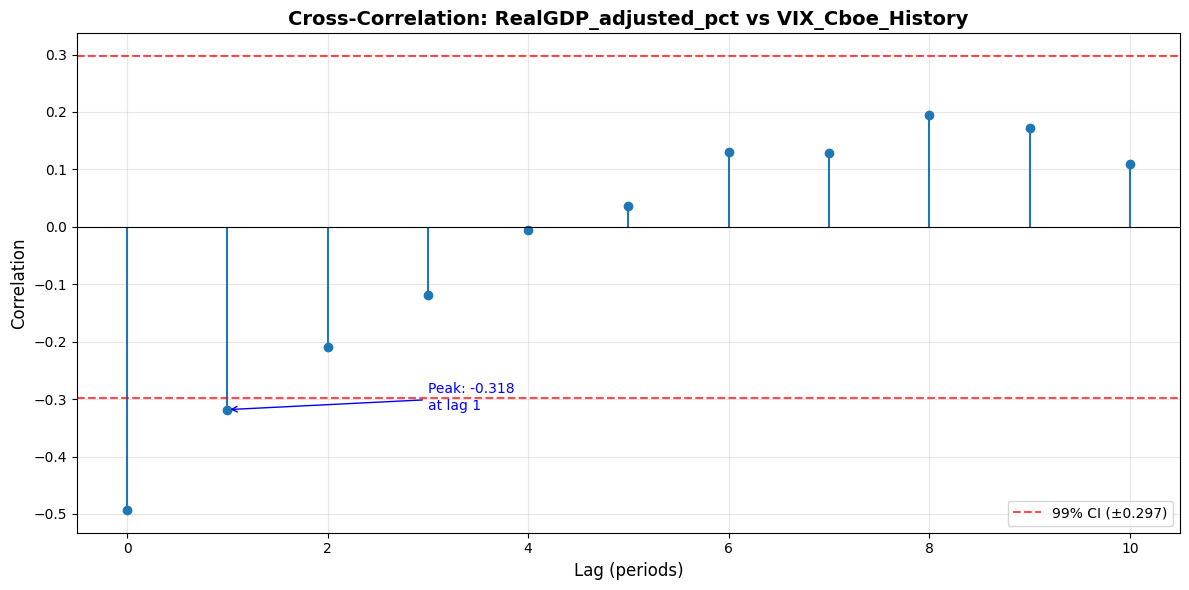


Cross-Correlation Analysis: RealGDP_adjusted_pct → VIX_Cboe_History
Sample size: 75
99% Confidence interval: ±0.297

Lag 0 correlation: -0.493
Peak correlation: -0.318 at lag 1

Significant lags: [0, 1]

Interpretation:
→ RealGDP_adjusted_pct LEADS VIX_Cboe_History by 1 period(s)
→ RealGDP_adjusted_pct changes predict VIX_Cboe_History changes 1 period(s) later
→ Negative relationship: variables move in opposite directions
→ Moderate correlation



In [70]:
correlations, sig_lags = analyze_ccf(dfs_dict_train, correlations_dict,
                                      name1='RealGDP_adjusted_pct',
                                      name2='VIX_Cboe_History')

In [72]:
print(dfs_dict_train['VIX_Cboe_History'].head())

             OPEN   HIGH    LOW  CLOSE
DateTime                              
1999-01-04  25.38  26.96  24.74  26.17
1999-01-05  25.92  25.98  24.36  24.46
1999-01-06  23.36  23.38  22.68  23.34
1999-01-07  24.42  24.90  24.04  24.37
1999-01-08  22.95  24.08  22.81  23.28


In [74]:
print(adfuller(dfs_dict_train['VIX_Cboe_History']['CLOSE'].dropna())[1])

0.00048785775521704685


In [78]:
for name, df in dfs_dict_train.items():
    if name == 'VIX_Cboe_History':
        print(f"{name} ADF p-value: {adfuller(df['CLOSE'].dropna())[1]} (Close Price)")
    elif name == 'S&P_500_Earnings_History':
        print(f"{name} ADF p-value: {adfuller(df.iloc[:, 0].dropna())[1]} (S&P 500)")
        print(f"{name} ADF p-value: {adfuller(df.iloc[:, 1].dropna())[1]} (EPS)")
    else:
        print(f"{name} ADF p-value: {adfuller(df.iloc[:, 0].dropna())[1]}")

10Yrs_Yield_unadjusted ADF p-value: 0.5630769672962276
CPI-U_unadjusted ADF p-value: 0.6080623622751696
FEDFUNDS ADF p-value: 0.04705028939709943
Industrial_Production ADF p-value: 0.13745334336584464
Initial_Jobless_Claims ADF p-value: 0.28682550803242074
MSCI_USA_Value_Index ADF p-value: 0.9971887020781859
RealGDP_adjusted ADF p-value: 0.9634881628406164
S&P_500_Earnings_History ADF p-value: 0.9967146475147345 (S&P 500)
S&P_500_Earnings_History ADF p-value: 0.5082646230594736 (EPS)
VIX_Cboe_History ADF p-value: 0.00048785775521704685 (Close Price)
CPI-U_unadjusted_pct ADF p-value: 0.00027166548242776466
RealGDP_adjusted_pct ADF p-value: 2.3622288865907573e-07


<Axes: title={'center': 'Real GDP Close Price percent change'}, xlabel='DateTime'>

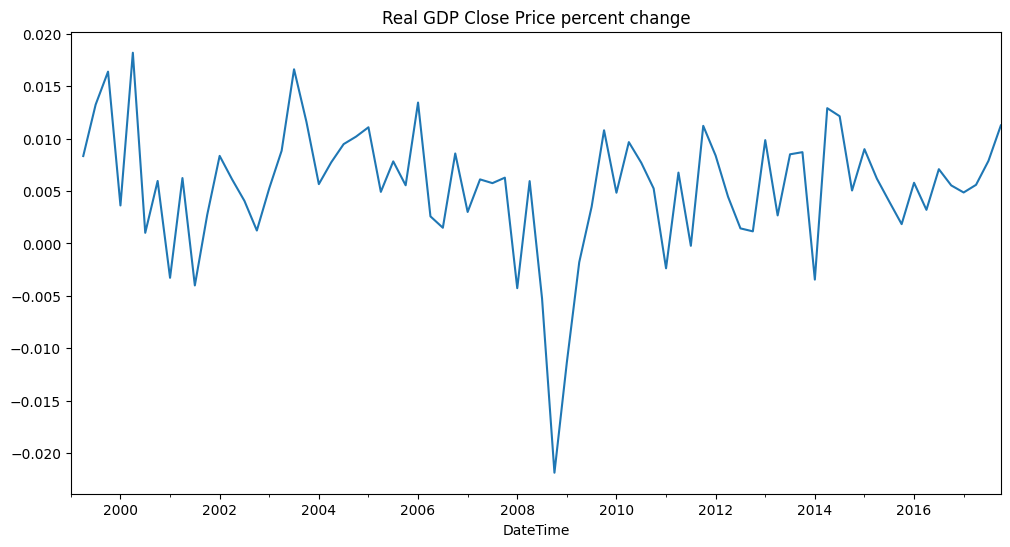

In [77]:
dfs_dict_train['RealGDP_adjusted_pct']['value1'].plot(title='Real GDP Close Price percent change', figsize=(12, 6))